
Digital Business University of Applied Sciences

Data Science und Management (M. Sc.)

RILE92 SP IV-2: Reinforcement Learning

Claudia Baldermann

Julia Schmid (200022)

***
#    Deep Q-Learning (DQN)
***

In diesem Jupyter-Notebook wird das Deep-Q-Learning (DQN) Verfahren in der Cliff Walking Umgebung von OpenAI (2022) trainiert und evaluiert.

In [147]:
from IPython.display import Image
Image(url='https://gymnasium.farama.org/_images/cliff_walking.gif',width=400)

**Import von den notwendigen Paketen**

In [148]:
# Imports
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Hyperparameter setzten**

In [150]:
# Hyperparameter
gamma = 0.99            # Diskontierungsfaktor
alpha = 0.005           # Lernrate
num_episodes = 1500    # Anzahl der Episoden

epsilon = 1.0           # Epsilon
epsilon_final = 0.1     # minmales Epsiloin 
epsilon_decay = 0.0002     #  Epsilon Reduzierungsfaktor

batch_size = 50         # Größe der Traingsbatches
buffer_size = 75        # Größe des Replay Buffers

N = 40                  # Aktualisierungsfaktor (Target-Netzwork)

**Reinforcement Umgebung definieren**

In [151]:
# Environment definieren (Cliff Walking)
env = gym.make('CliffWalking-v0')

#Bestimmung der Anzahl der möglichen Zustände
state_size = env.observation_space.n # 48 Zustände
print(f"Anzahl der Zustände: {state_size}")

#Bestimmung der Anzahl der möglichen Aktionen
action_size = env.action_space.n # 4 Aktionen 
print(f"Anzahl der Aktionen: {action_size}")

Anzahl der Zustände: 48
Anzahl der Aktionen: 4


**Funktionen für das DQN definieren**

In [152]:
# Funktion: Erstellung eines neuronalen Netzes mit Pytorch
# Input: state_size (Anzahl der möglichen Zustände), action_size (Anzahl der möglichen Aktionen) 
# Output: network (neuronales Netz)
# Funktionsweise: Es wird ein neuronales Netz definiert, welches aus einer Eingabeschicht (Anzahl der Zustände), einer versteckten Schickt mit 64 Neurononen und einer Ausgabeschickt (Anzahl der Aktion) besteht. Es wird die Aktivierungsfunktion ReLu angewendet. 

class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = nn.Linear(state_size, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)

    def forward(self, s):
        x = F.relu(self.hidden1(s))
        x = F.relu(self.hidden2(x))
        return self.output(x)
    
# Quelle: Paszke (2024)

In [153]:
# Funktion: Auwahl einer Aktion nach der Epsilon-Greedy-Strategie
# Input: state (aktueller Zustand), q_network (Q-Netzwerk), epsilon (Epsilon)
# Output: action (Aktion)
# Funktionsweise: Per Zufall (np.random.rand()) wird entschieden, ob Exploration (Auswahl einer zufälligen Aktion) oder Exploitation (Auswahl der besten Aktion) gewählt wird.

def select_action(state, q_network, epsilon):
    if np.random.rand() <= epsilon: # Exploration
        action=  env.action_space.sample()  # Auswahl einer zufällige Aktion
        return action
    else: # Exploitation
        with torch.no_grad(): # Deaktivierung der automatischen Berechnung von Gradienten
            state_tensor = torch.eye(state_size)[state].unsqueeze(0) # Umwandlung der State in Vektor (für neuronales Netz)
            q_values = q_network(state_tensor)  # Q-Wert bestimmen
            action = torch.argmax(q_values).item() # Auwahl der Aktion mit höchsten Q-Wert
            return action

# Quelle: In Anlehnung an Géron (2019)

In [154]:
# Funktion: Trainingsprozess
# Input: replay_buffer (Replay Buffer), qNetwork_model (Q-Netzwerk), targetNetwork_model (Target-Netzwerk), optimizer (Optimizer für neuronale Netze), batch_size (Größe der Traingsbatches), state_size (Anzahl der möglichen Zustände)
# Output: loss.item() (Verlustwert)
# Funktionsweise: Es wird eine Batch (zufällige Stichprobe) aus dem Replay Buffer gezogen, basierend darauf werden die Q-Werte vom Q-Netzwerk und Target-Netzwerk bestimmt. Mit diesen Werten wird der Loss (Verlust) bestimmt. 

def train(replay_buffer, qNetwork_model, targetNetwork_model, optimizer, batch_size, state_size):
    replay_buffer_batch = random.sample(replay_buffer, batch_size) # Es wird ein Batch (zufällige Stichprobe) aus dem Replay-Buffer gezogen
    states, actions, rewards, state_next, dones = zip(*replay_buffer_batch)  # Speicherung der einzelnen Komponenten aus dem Replay-Buffer Batch 
    # Speicherung der Komponenten im richtigen Format
    states = torch.eye(state_size)[list(states)]
    actions = torch.tensor(actions)
    state_next = torch.eye(state_size)[list(state_next)]
    rewards = torch.tensor(rewards, dtype=torch.float32)
    dones = torch.tensor([float(done) for done in dones], dtype=torch.float32)

    # Verwendung des Q-Netzwerks und des Target-Netzwerks um die Loss-Funktion zu bestimmen:  
    q_values = qNetwork_model(states).gather(1, actions.unsqueeze(1)).squeeze() # Bestimmung der Q-Werte aus dem Q-Netzwerk 
    next_q_values = targetNetwork_model(state_next).max(1)[0].detach() # Bestimmung des besten Q-Wertes für den nächsten Zustand 
    target_q_values = rewards + gamma * next_q_values * (1 - dones) # Zielwert des Target-Netzwerks 

    loss = F.mse_loss(q_values, target_q_values) # Bestimmung des Verlustes (loss) mittels MSE 

    optimizer.zero_grad() # Löschung der Gradienten
    loss.backward() # Bestimmung der Gradienten
    optimizer.step() # Aktualisierung der Modellparameter

    return loss.item()

# Quelle: In Anlehnung an Géron (2019)

**DQN Anwenden auf definierte Umgebung**

In [155]:
reward_records = [] # Leere Liste für die Speicherung der erhaltenen gesamt Rewards (gesamte Belohnungen) (Für die Evaluation) 
loss_records = [] # Leere Liste für die Speicherung der durchschnittlichen Loss Werte pro Episode (Für die Evaluation) 

qNetwork = NeuralNetwork(state_size, action_size) # Inizialisierung des Q-Netzwerks 
targetNetwork = NeuralNetwork(state_size, action_size) # Inizialisierung des Target-Netzwerks
targetNetwork.load_state_dict(qNetwork.state_dict()) # Target-Nertwerk erhält die gleichen Gewichte wie das Q-Netzwerk
optimizer = optim.Adam(qNetwork.parameters(), lr=alpha) # Adam-Optimizer, welcher die Gewichte (qNetwork.parameters()) mittels Gradientenabstiegs aktualisiert 

# Inizialisierung des Replay-Buffers
replay_buffer = deque(maxlen=buffer_size) 

for episode in range(num_episodes):
    # Initialisierung
    state = env.reset()[0]  
    total_reward = 0
    total_loss = 0
    count_loss = 0
    done = False  
        
    while not done:
        action = select_action(state, qNetwork, epsilon)  # Es wird eine Aktion gewählt (epsilon-Greedy)
        state_next, reward, done, _, _ = env.step(action)  # Es wird die ausgewähle Aktion a ausgeführt und basierend auf der ausgeführten Aktion der nächste Zustand s' (state_next), die Belohnung r (reward) und der Done-Zustand (done) gespeichert

        replay_buffer.append((state, action, reward, state_next, done))  # Zustand, Aktion, Belohnung und nächster Zustand werden im Replay-Buffer gespeichert
        
        state = state_next # Aktualisierung des aktuellen Zustands (Bewegung)
        total_reward += reward  # Aktualisierung der gesamten Belohnungen 
            
        ## Training beginnt erst, wenn eine Anzahl von Erfahrungen (batch_size) gesammelt worden sind
        if len(replay_buffer) < batch_size:
            continue
        # Sobald genügend Erfahrungen gesammelt werden, beginnt das Training
        else:
            loss = train(replay_buffer, qNetwork, targetNetwork, optimizer, batch_size, state_size)
            if loss is not None:
                total_loss += loss
                count_loss += 1
    
    reward_records.append(total_reward) # Speicherung der gesamten Belohnungen

                
    # Alle N Schritte wernde die Gewichte des Target-Nertwerks aktualisiert
    if episode % N == 0:
        targetNetwork.load_state_dict(qNetwork.state_dict())

    # Berechnung des durchschnittlichen Verlusts pro Episode
    loss_averange = 0
    if count_loss > 0:
        loss_records.append(total_loss / count_loss)
        loss_averange = total_loss / count_loss
    else:
        loss_records.append(0)
        loss_averange = 0

    # Aktualisierung von Epsilon
    epsilon = max(epsilon_final, epsilon - epsilon_decay)
                
    print(f"Episode {episode} of {num_episodes}, Reward: {total_reward}, Epsilon: {epsilon:.3f}, Loss avg.: {loss_averange:.3f}", end="\r")

env.close()
print("\nDone")

# Quelle: In Anlehnung an Géron (2019) und Ravichandiran (2018)

Episode 1499 of 1500, Reward: -13, Epsilon: 0.100, Loss avg.: 0.015378
Done


**Evaluierung**

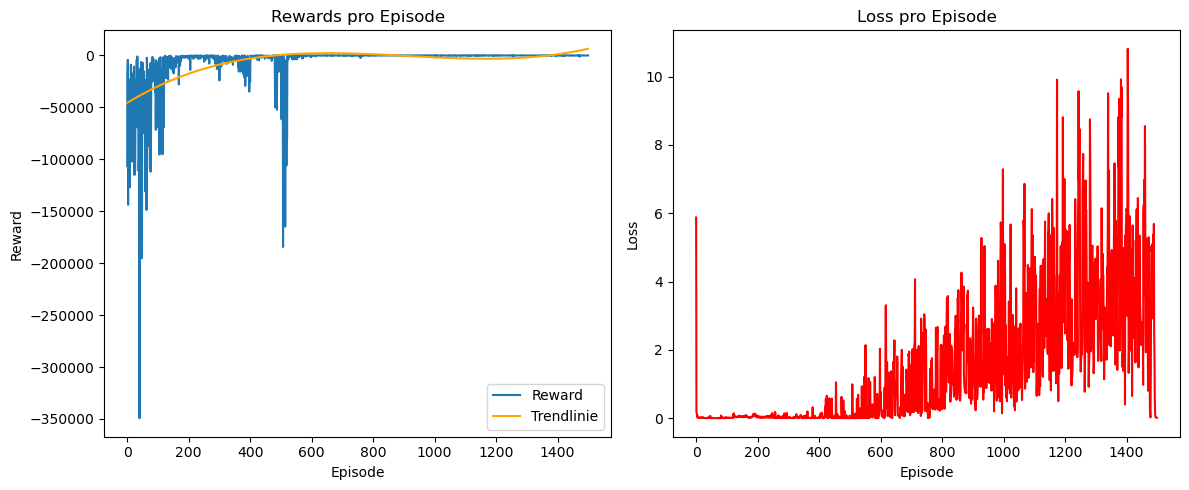

In [156]:
episodes = list(range(len(reward_records)))  # Anzahl der Episoden
losses = loss_records  # Gespeicherte Verluste
rewards = reward_records  # Gespeicherte Rewards

plt.figure(figsize=(12, 5))
# Rewards pro Episode
plt.subplot(1, 2, 1)
plt.plot(range(len(rewards)), rewards, label="Reward")
# Trendlinie einfügen
# poly_coeffs = np.polyfit(range(len(rewards)), rewards, 3)
poly_trend = np.poly1d(np.polyfit(range(len(rewards)), rewards, 3))
# x_vals = np.arange(len(rewards))
plt.plot(np.arange(len(rewards)), poly_trend(np.arange(len(rewards))), label="Trendlinie", color="orange")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards pro Episode")
plt.legend()
# Verlust pro Episode
plt.subplot(1, 2, 2)
plt.plot(range(len(losses)), losses, label="Loss", color='red')
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss pro Episode")
plt.tight_layout()
plt.show()


***
***